In [1]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
import os
import seaborn as sns
import statsmodels.api as sm
import pylab as py

# seaborn graphics settings
sns.set(color_codes=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Show current working directory
print(os.getcwd())

C:\Users\AnninaBerweger\datascience-immo\Immo-Projekt-DataScience


In [2]:
#DB-Connection 
driver = '{ODBC Driver 17 for SQL Server}' # This might be a different version on your system
server = 'ANNINAYOGA\SQLEXPRESS'
database = 'Immo'
username = 'immoadmin'
password = 'zhaw$1234'
connection_string = f"DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;"

In [3]:
#Connection and SQL-Query for table property
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM property"
df_property = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]
cnxn.close()

#Connection and SQL-Query for table location
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM location"
df_location = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]
cnxn.close()

# Performing a inner join on the two DataFrames to filter data which do not exist on location due to connection issues
df_filtered_property_location = pd.merge(df_property, df_location,on='LocationId', how='inner')


# Data Cleansing for Location-Property

In [4]:
#Show head of df df_filtered_property_location
df_filtered_property_location.head()

,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,NetPrice,LocationId,PropertyAdditionalFeaturesId,PropertyDescription,Vendor,Canton,Street,ZIP,longitude,latitude
0,4000339592,2024-03-26 20:51:38,2.5,93.0,1,Sofort,Wohnung,2020-01-01,1920.0,NaN,1920.0,8410960a-1d36-40e9-940c-045cb7ea0657,65f95f08-2ad6-46aa-88a8-3d60b251686d,"La Residenza Delta si trova a Capolago, situat...",Interfida SA,ti,Via Carlo Maderno 62,6825,8.9550861,46.0096811
1,4000280848,2024-03-26 20:51:50,2.5,62.0,2,Sofort,Wohnung,2017-01-01,1730.0,280.0,1450.0,fe87a1a0-0607-4532-91f9-9b52325d901c,47fb2685-0d55-4201-b7b2-65c7c4797f7a,"La Residenza Martina, progettata dall’Architet...",Tarchini Group,ti,Via Indipendenza 10b,6826,11.3427643,44.4965102
2,4000653378,2024-03-26 21:52:37,2.0,58.0,3,Nach Vereinbarung,Wohnung,None,910.0,160.0,750.0,c1e83bdc-405d-41b3-9836-92ecd15a3138,8cff0e4e-2acb-4d04-906b-d76a6ca54d17,Affittasi 2 locali grazioso e luminoso in un q...,Livit AG,ti,Via Cereghetti 8,6834,9.0166712,45.8522512
3,4000381531,2024-03-26 22:44:33,1.5,40.0,None,Sofort,Wohnung,None,1350.0,100.0,1250.0,eaf7aae5-0fd2-4063-ab10-1ef432b1fe71,b8b96c50-b41f-489a-a908-0ef31a44f60d,"Siamo a Pazzallo, a circa 10 minuti dal centro...",Rusca Studio Immobiliare,ti,None,6912,None,None
4,4000263143,2024-03-26 20:52:41,2.5,50.0,99,Nach Vereinbarung,Wohnung,None,1300.0,NaN,1300.0,c9939627-0caf-4c2e-b11a-aee3bc6afad5,9b110e2e-24c6-4920-a41b-c46378f2e346,A Bissone affittiamo appartamento arredato di ...,Zenit Real Estate Sagl,ti,Via Campione 65,6816,None,None


In [5]:
#Show info of df df_filtered_property_location. Total of 11295 entries
df_filtered_property_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11295 entries, 0 to 11294
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     11295 non-null  object        
 1   Timestamp                     11295 non-null  datetime64[ns]
 2   Rooms                         10896 non-null  float64       
 3   SquareMeter                   9296 non-null   float64       
 4   Floor                         9578 non-null   object        
 5   Availability                  11294 non-null  object        
 6   ObjectType                    11294 non-null  object        
 7   YearBuilt                     4969 non-null   object        
 8   Price                         11295 non-null  float64       
 9   AdditionalCost                9270 non-null   float64       
 10  NetPrice                      10055 non-null  float64       
 11  LocationId                  

In [6]:
#Check for duplicates - no duplicates found
df_filtered_property_location.duplicated().sum()

0

# Check for empty entries and filter records

In [7]:
#dataframe df_filtered_property_location_clean  
#ObjectType where Einzelzimmer, Estrichabteil, Hobbyraum, Kellerabteil - filtered
#Rooms where NULL - filtered
#SquareMeter where NULL - filtered
#total: 9024 entries (original: 11295 entries)
#Outliers - check Outliers of Prices, Rooms and SquareMeters. Eliminate manually where not noisy data 
#total after eliminating noisy data: 9000 entries (original 11295 entries)

In [8]:
# filter out records with empty strings in the 'Rooms' column - new dataframe: df_filtered_property_location_clean
df_filtered_property_location_clean = df_filtered_property_location[df_filtered_property_location['Rooms'].notna()]

In [9]:
#Check ObjectTypes
df_filtered_property_location.groupby("ObjectType").size()

ObjectType
Attikawohnung             318
Bauernhaus                  6
Chalet                     40
Dachwohnung               300
Doppeleinfamilienhaus      28
Einfamilienhaus           281
Einliegerwohnung            9
Einzelzimmer               98
Estrichabteil               2
Hobbyraum                 122
Kellerabteil               11
Loft                       71
Maisonette / Duplex       359
Mansarde                    1
Mehrfamilienhaus            2
Reihenfamilienhaus         58
Studio                    151
Terrassenhaus               4
Terrassenwohnung           38
Villa                      66
Wohnung                  9329
dtype: int64

In [10]:
#Filter where ObjectType != Einzelzimmer, Estrichabteil, Hobbyraum or Kellerabteil
df_filtered_property_location_clean = df_filtered_property_location[(df_filtered_property_location['ObjectType'] != 'Einzelzimmer') & (df_filtered_property_location['ObjectType'] != 'Estrichabteil') & (df_filtered_property_location['ObjectType'] != 'Hobbyraum') & (df_filtered_property_location['ObjectType'] != 'Kellerabteil')]

#Check ObjectTypes - Einzelzimmer, Estrichabteil, Hobbyraum or Kellerabteil are filtered
df_filtered_property_location_clean.groupby("ObjectType").size()

ObjectType
Attikawohnung             318
Bauernhaus                  6
Chalet                     40
Dachwohnung               300
Doppeleinfamilienhaus      28
Einfamilienhaus           281
Einliegerwohnung            9
Loft                       71
Maisonette / Duplex       359
Mansarde                    1
Mehrfamilienhaus            2
Reihenfamilienhaus         58
Studio                    151
Terrassenhaus               4
Terrassenwohnung           38
Villa                      66
Wohnung                  9329
dtype: int64

In [11]:
# filter out records with empty strings in the 'Rooms' and 'SquareMeters' column
df_filtered_property_location_clean = df_filtered_property_location.dropna(subset=['Rooms', 'SquareMeter'])

#Check for empty records
df_filtered_property_location_clean.isnull().sum()

ListingId                          0
Timestamp                          0
Rooms                              0
SquareMeter                        0
Floor                           1081
Availability                       0
ObjectType                         0
YearBuilt                       4428
Price                              0
AdditionalCost                  1482
NetPrice                         917
LocationId                         0
PropertyAdditionalFeaturesId       0
PropertyDescription               37
Vendor                           652
Canton                             0
Street                           550
ZIP                                0
longitude                       9024
latitude                        9024
dtype: int64

In [12]:
#9024 entries after filtered
df_filtered_property_location_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9024 entries, 0 to 11294
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     9024 non-null   object        
 1   Timestamp                     9024 non-null   datetime64[ns]
 2   Rooms                         9024 non-null   float64       
 3   SquareMeter                   9024 non-null   float64       
 4   Floor                         7943 non-null   object        
 5   Availability                  9024 non-null   object        
 6   ObjectType                    9024 non-null   object        
 7   YearBuilt                     4596 non-null   object        
 8   Price                         9024 non-null   float64       
 9   AdditionalCost                7542 non-null   float64       
 10  NetPrice                      8107 non-null   float64       
 11  LocationId                    9024

<Axes: xlabel='SquareMeter'>

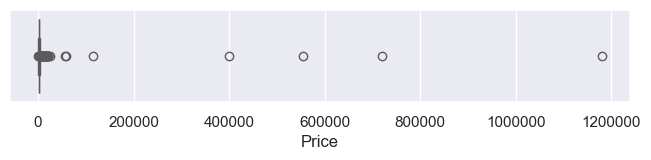

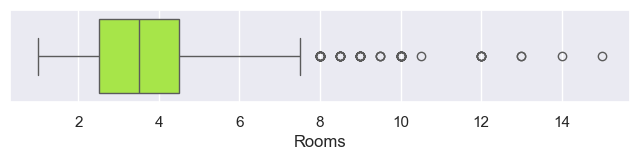

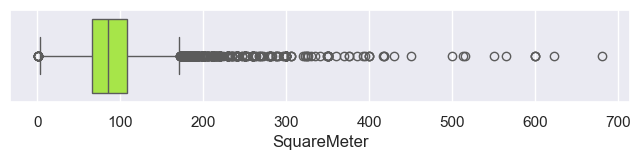

In [13]:
#Boxplots for Outliers of Prices, Rooms and SquareMeters
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Price'], color="greenyellow")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Rooms'], color="greenyellow")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['SquareMeter'], color="greenyellow")

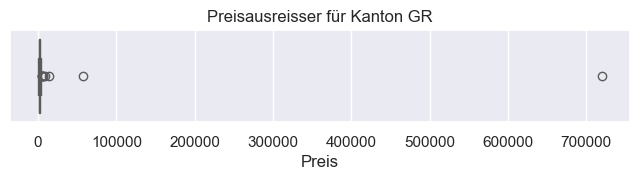

In [14]:
#Show outlier for specific canton
df_gr = df_filtered_property_location_clean[df_filtered_property_location_clean['Canton'] == 'gr']
plt.figure(figsize=(8, 1.2))
plt.ticklabel_format(style='plain')  # Stellt sicher, dass die Preise im normalen Zahlenformat angezeigt werden
sns.boxplot(x=df_gr['Price'], color="greenyellow")  # Erstellen des Boxplots mit der angegebenen Farbe

plt.title('Preisausreisser für Kanton GR')  # Hinzufügen eines Titels zum Plot
plt.xlabel('Preis')  # Beschriftung der X-Achse
plt.show()

In [15]:
#Detect outliers (Price) and list them

# Set display options
pd.set_option('display.max_rows', 50)

# Calculation of the first (Q1) and third quartiles (Q3) for Price across the entire DataFrame
Q1 = df_filtered_property_location_clean['Price'].quantile(0.25)
Q3 = df_filtered_property_location_clean['Price'].quantile(0.75)
IQR = Q3 - Q1

# Boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = df_filtered_property_location_clean[(df_filtered_property_location_clean['Price'] < lower_bound) | (df_filtered_property_location_clean['Price'] > upper_bound)]

# Feedback if there are any outliers
if outliers.empty:
    print("No outliers found.")
else:
    # Sort outliers by the 'Price' column in descending order
    outliers_sorted = outliers.sort_values(by='Price', ascending=False)
    
    # Display sorted outliers
    print("Outliers found, sorted by highest price:")
    display(outliers_sorted)


Outliers found, sorted by highest price:


,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,NetPrice,LocationId,PropertyAdditionalFeaturesId,PropertyDescription,Vendor,Canton,Street,ZIP,longitude,latitude
9846,4000895043,2024-03-29 14:01:53,4.5,92.0,EG,15.12.2024,Wohnung,None,1180000.0,NaN,1180000.0,af6ba0a2-e44d-418a-9893-b2684d995519,39b703b3-4ff4-4036-9629-d0bb24723963,Belle appartement de 4.5 pièces au rez-de-chau...,Familia Plan SA,vd,Avenue Abraham-Hermanjat 12,1170,None,None
7412,4000956535,2024-03-27 14:46:17,3.5,139.0,EG,Nach Vereinbarung,Wohnung,1965-01-01,720000.0,NaN,NaN,1da13540-56f7-42ab-8d0e-c652093be5d6,d1dbc313-f37b-45dc-a5af-19ae94e1d7fc,Das Haus wurde 1965 gebaut und im Jahr 2021 vo...,Diala Treuhand AG,gr,Schaivel 14B,7537,None,None
8305,4000834270,2024-03-26 05:49:47,2.5,67.0,EG,31.03.2027,Wohnung,2024-01-01,554000.0,NaN,NaN,a19fb5ad-9507-4252-a88c-53257c9dc8b3,a927e8e1-f8ac-4089-8868-250fa7333d90,Siamo lieti di presentarvi il nuovo progetto S...,Arch MNG Sagl,ti,Via Prati,6855,None,None
7883,4000895759,2024-03-25 21:29:48,2.5,63.0,EG,Sofort,Wohnung,2023-01-01,399000.0,NaN,NaN,cb603e56-fff5-4985-9eec-7c57e0d9f732,ec9f5ac5-c3d0-4818-b8f4-683b2b31c0a2,Vieni a scoprire il tuo angolo di paradiso nel...,Sanz Corporation Sagl,ti,None,6998,None,None
6204,3003516605,2024-03-24 13:08:32,10.0,350.0,None,Sofort,Chalet,1930-01-01,115000.0,NaN,NaN,cc5d4d24-2090-4fbd-92dd-d31f49353433,62fae7b0-6e6e-4814-a96f-80af2bb53ed1,ObjektbeschreibungDieses charmante und grossrä...,nk immobilien gstaad gmbh,be,Alpinastrasse 15,3780,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,4000887932,2024-03-27 21:59:19,4.5,110.0,5,Sofort,Attikawohnung,2024-01-01,3690.0,250.0,3440.0,7900cd3f-a8a7-4e7f-a3f4-64d473cefc9b,5c3f8499-50d0-41da-82a0-8489f126a6cb,"Wir freuen uns, Ihnen diese erstklassige 4.5-Z...",EMPERIO AG,ag,None,5400,None,None
10995,4000871115,2024-03-29 21:54:59,5.0,116.0,1,Nach Vereinbarung,Wohnung,None,3690.0,190.0,3500.0,879dc58b-6c0b-4f8a-8df4-6972a677ee14,7ed41f9e-1baf-4ca2-aa0a-4931b621d82f,"Cet appartement en excellent état, se situe da...",Comptoir Immobilier Genève,ge,route de Bellebouche 2,1246,None,None
5327,4000890770,2024-03-24 02:59:08,4.5,133.0,-1,Nach Vereinbarung,Wohnung,2023-01-01,3690.0,330.0,3360.0,c8988a9d-d709-4dab-af6b-0997a779ef0a,52cb60b1-4e4c-40c4-98c8-15571627dc37,An ruhiger- und naturnaher Lage vermieten wir ...,Kübler Immobilien AG,zh,Mörsburgstrasse 18,8472,None,None
4973,4000888372,2024-03-24 01:48:25,4.5,132.0,None,Nach Vereinbarung,Wohnung,None,3690.0,450.0,3240.0,20041a3d-3925-4356-96e4-179c461a4a3e,933c795c-f506-475f-92bc-525f7f0d2cf3,Diese aussergewöhnliche und exklusive Villa Wo...,Wohnplus AG,zh,Alter Zürichweg 16,8952,None,None


In [16]:
#Detect outliers (Rooms) and list them

# Set display options
pd.set_option('display.max_rows', 500)

# Calculation of the first (Q1) and third quartiles (Q3) for Price across the entire DataFrame
Q1 = df_filtered_property_location_clean['Rooms'].quantile(0.25)
Q3 = df_filtered_property_location_clean['Rooms'].quantile(0.75)
IQR = Q3 - Q1

# Boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = df_filtered_property_location_clean[(df_filtered_property_location_clean['Price'] < lower_bound) | (df_filtered_property_location_clean['Price'] > upper_bound)]

# Feedback if there are any outliers
if outliers.empty:
    print("No outliers found.")
else:
    # Sort the outliers by the 'Price' column in descending order
    outliers_sorted = outliers.sort_values(by='Rooms', ascending=False)
    
    # Display the sorted outliers
    print("Outliers found, sorted by highest Rooms:")
    display(outliers_sorted)



Outliers found, sorted by highest Rooms:


,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,NetPrice,LocationId,PropertyAdditionalFeaturesId,PropertyDescription,Vendor,Canton,Street,ZIP,longitude,latitude
8096,4000747603,2024-03-26 23:12:08,15.0,43.0,99,Nach Vereinbarung,Wohnung,None,2900.0,NaN,2900.0,289452ad-f85e-49cb-9643-53722c88ec42,e24ee7d2-8c6c-4fa1-8da1-b17e1ab81129,Proponiamo in affitto lussuoso appartamento am...,Zenit Real Estate Sagl,ti,Viale Castagnola,6900,None,None
3077,4000360406,2024-03-26 22:45:34,14.0,416.0,None,Nach Vereinbarung,Wohnung,None,6760.0,NaN,6760.0,b0e46434-4733-44a1-9bcf-db432a14a730,1dfff494-2476-4b75-9989-a26691a4b845,Ufficio già cablato con cavi di rete e funghi ...,Engel & Völkers Lugano,ti,None,6834,None,None
11146,4000853321,2024-03-29 22:28:33,13.0,418.0,3,Sofort,Wohnung,None,12700.0,800.0,11900.0,d5d4e6e7-9872-4591-b988-5c2ab776045f,6b5d5b2a-c307-4a9d-9610-465463de9671,Superbe 13 pièces à Champel avec 5 chambres et...,Zimmermann Immobilier SA,ge,Avenue Krieg 19,1208,None,None
11160,4000976047,2024-03-29 22:33:07,13.0,418.0,None,Nach Vereinbarung,Wohnung,None,12200.0,800.0,11400.0,92f028ed-1ce5-496e-9a6f-a03174672612,3a42642b-d62c-4bed-824a-23987df6b39c,Réf FM260: Dans un quartier verdoyant et calm...,Luxity,ge,avenue de krieg,1206,None,None
11272,4000491604,2024-03-29 22:58:49,12.0,392.0,45,Nach Vereinbarung,Maisonette / Duplex,None,18000.0,NaN,18000.0,a81aa236-e8bf-41ef-acd1-e878b5a7268c,d550ed3d-5845-40a0-94a5-d8507cefcadf,Disponible de suite Avec une surface habitable...,IMMOMATTER & Associés Sàrl,ge,place jean marteau,1201,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,4000937788,2024-03-26 21:29:48,1.0,25.0,3,Sofort,Wohnung,None,680.0,80.0,600.0,1fc15b7f-70b1-4906-9ad5-e4d86cff8de5,9c27f1f8-0ebb-4307-b810-2a29ca5687aa,Affittasi da subito in Via Concordia 14 a Luga...,Immobiliare De Bernardis,ti,Via Concordia 14,6900,None,None
10254,4000867718,2024-03-29 18:15:13,1.0,17.0,4,Sofort,Wohnung,None,600.0,50.0,550.0,1c2ce98e-eea7-478e-8c00-c88236e3cbef,61e1c3d7-3635-4176-b0d0-5f885cb86118,"A louer, au centre de Sion, à 5 minutes à pied...",Domicim - Location,vs,Av. de Tourbillon 46,1950,None,None
1280,4000161638,2024-03-27 17:20:03,1.0,48.0,2,Sofort,Studio,None,850.0,50.0,800.0,f8af3b53-8176-46b0-8008-9e1c56e83e9e,94edb258-ee3e-4c78-be95-d06331cedd32,"! Un mois de loyer offert !Joli studio de 48,8...",Juracool.ch Sarl,ju,None,2902,None,None
7932,3003296216,2024-03-27 10:21:38,1.0,24.0,1,Sofort,Wohnung,2022-01-01,1090.0,90.0,1000.0,6d6f2470-05f3-4913-bfce-1015cacfe951,8327f01e-d98f-44c4-bce5-746a1ce70cc1,Neu renovierte Studio-Wohnungen ab sofort zu v...,Goda Verwaltung,sz,Bahnhofstrasse 172,6423,None,None


In [17]:
#detect outliers (SquareMeter) and list them

# Set display options
pd.set_option('display.max_rows', 50)

# Calculation of the first (Q1) and third quartiles (Q3) for Price across the entire DataFrame
Q1 = df_filtered_property_location_clean['SquareMeter'].quantile(0.25)
Q3 = df_filtered_property_location_clean['SquareMeter'].quantile(0.75)
IQR = Q3 - Q1

# Boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = df_filtered_property_location_clean[(df_filtered_property_location_clean['SquareMeter'] < lower_bound) | (df_filtered_property_location_clean['Price'] > upper_bound)]

# Feedback if there are any outliers
if outliers.empty:
    print("No outliers found.")
else:
    # Sort the outliers by the 'Price' column in descending order
    outliers_sorted = outliers.sort_values(by='SquareMeter', ascending=False)
    
    # Display the sorted outliers
    print("Outliers found, sorted by highest SquareMeter:")
    display(outliers_sorted)

Outliers found, sorted by highest SquareMeter:


,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,NetPrice,LocationId,PropertyAdditionalFeaturesId,PropertyDescription,Vendor,Canton,Street,ZIP,longitude,latitude
88,4000634700,2024-03-26 21:53:23,6.5,680.0,EG,Nach Vereinbarung,Villa,2012-01-01,20000.0,NaN,20000.0,ae703238-bef2-407d-a532-fdce214b1065,a558f098-1208-4bf7-8e62-c92aebc278c4,Comano. In posizione privilegiata proponiamo i...,SIT Immobiliare - Studio immobiliare Ticino,ti,None,6949,None,None
2687,4000869508,2024-03-27 08:42:30,10.0,622.0,None,Nach Vereinbarung,Villa,1986-01-01,9900.0,NaN,NaN,25dba0de-2406-46ea-9e42-09d51678547f,7d953df0-f341-46b4-bbaf-9778259bed4e,Diese grosszügige 10 Zimmer-Villa Auf dem Stei...,IBSG AG,ar,Auf dem Stein 2245,9052,None,None
8225,4000611388,2024-03-25 22:19:29,7.5,600.0,None,Nach Vereinbarung,Einfamilienhaus,None,18000.0,NaN,18000.0,00839389-f52a-46d2-88d0-02d5b6f73b07,ae49d109-2afd-4c37-9d9e-9036a000419b,Questa meravigliosa villa vicina al lago e al ...,TG Real Estate,ti,Lugano,6900,None,None
9925,3000029481,2024-03-29 14:20:24,8.0,600.0,None,Sofort,Chalet,2008-01-01,10000.0,NaN,NaN,d69ec4cd-5882-43bf-88ce-108bc276741d,bc06eaa2-f1fb-4982-9e21-f2bbddbdcee8,L'agence immobilière Bauma / Scheuchzer Immobi...,Agence Bauma,vd,Chalet Rose des Vents,1865,None,None
10250,4000943404,2024-03-29 18:13:13,12.0,600.0,None,Nach Vereinbarung,Chalet,None,13000.0,NaN,13000.0,90bcb203-de74-41df-bc0b-917559eeee29,a3f899a6-6c77-488f-9e5a-bf0428722f18,"Splendide chalet sur 4 niveau, pour 14 person...",Agence Barras,vs,Rue des Anémones 17,3963,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,4000931326,2024-03-24 03:33:00,4.5,1.0,2,01.04.2024,Wohnung,1898-01-01,1699.0,510.0,1189.0,6e4a0897-b0f0-4ecc-9ecf-f96fc33f097f,ed75504e-82f4-4398-bc95-3c4fd2b9934e,Wir sind auf der Suche nach neuen Mietern für ...,Livit AG,zh,Seestrasse 342,8810,None,None
3108,4000906960,2024-03-27 10:41:49,1.0,1.0,1,Sofort,Einzelzimmer,None,828.0,NaN,NaN,48af770a-df21-460c-9543-f2766b5219f3,1b6f7b97-54c7-4530-af35-50e4bcc16361,Per 1. April 2024 vermieten wir ein Zimmer in ...,immo1 GmbH,sz,Churerstrasse 109,8808,None,None
8524,4000969684,2024-03-29 08:41:29,3.0,1.0,1,01.05.2024,Wohnung,None,1740.0,NaN,1740.0,c3cf00e9-0884-4cdd-9deb-62163bbc542b,6d79dca2-7383-45f5-97f8-fe4969a0bc3b,"Très jolie appartement pièces à courtepin, Gra...",https://sherlockhomes.ch,fr,Impasse de la Gravonna,1784,None,None
3525,4000962388,2024-03-27 22:14:14,2.5,1.0,EG,01.07.2024,Wohnung,None,1254.0,160.0,1094.0,9f9f43ee-c793-491b-bf61-9aee7d2eb082,541634ff-1fbd-4c4f-9f08-7d17a8b95397,Per 01.07.2024 vermieten wir eine moderne 2.5-...,Livit AG,ag,Breitestrasse 56a,5734,None,None


In [19]:
#Outliers manually checked if records is valid or not (if not valid (selling house instead of renting), to delete
# List of ListingIds to be removed (selling instead of renting objects, shared apartments,...)
ids_to_remove = ['4000895043','4000834270','4000895759','3003516605','4000910516','4000956535','4000924121','4000975051','4000888412','4000945522','4000869481','4000969667','4000838419','4000870455','4000904681','4000931326','4000969684','4000969684','4000797599','4000897187','4000969553','4000969553','4000965774','4000962388','4000969516','4000906960']  
df_filtered_property_location_clean = df_filtered_property_location_clean[~df_filtered_property_location_clean['ListingId'].isin(ids_to_remove)]


In [20]:
#9000 entries after filtered
df_filtered_property_location_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 0 to 11294
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     9000 non-null   object        
 1   Timestamp                     9000 non-null   datetime64[ns]
 2   Rooms                         9000 non-null   float64       
 3   SquareMeter                   9000 non-null   float64       
 4   Floor                         7922 non-null   object        
 5   Availability                  9000 non-null   object        
 6   ObjectType                    9000 non-null   object        
 7   YearBuilt                     4588 non-null   object        
 8   Price                         9000 non-null   float64       
 9   AdditionalCost                7534 non-null   float64       
 10  NetPrice                      8096 non-null   float64       
 11  LocationId                    9000

<Axes: xlabel='SquareMeter'>

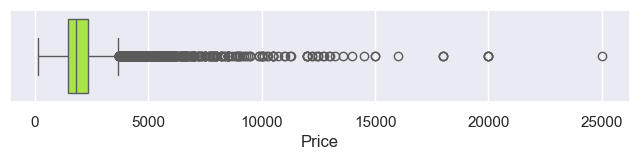

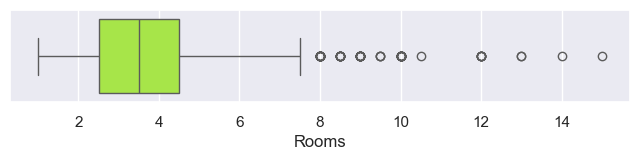

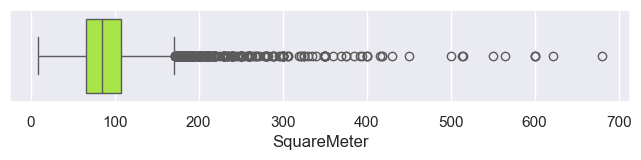

In [21]:
#Boxplots after eliminating noisy data for Outliers of Prices, Rooms and SquareMeters
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Price'], color="greenyellow")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Rooms'], color="greenyellow")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['SquareMeter'], color="greenyellow")

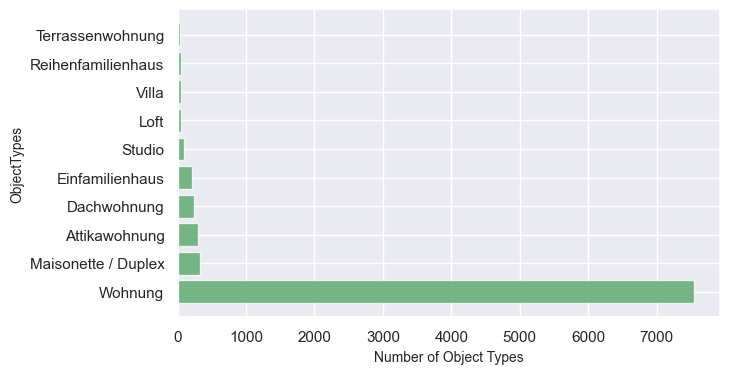

In [22]:
# Barchart top 10 ObjectTypes
#Group data by ObjectType (only the topmost 10 values are shown)
df_bar_property = df_filtered_property_location_clean['ObjectType'].value_counts().nlargest(10).sort_values(ascending=False)

# Values for barchart
napart = list(df_bar_property.values)
index = list(df_bar_property.index.values)
y_pos = np.arange(len(index))

# Figure
fig, ax = plt.subplots(figsize=(7,4))
ax.barh(y_pos, napart, align='center', color='g', alpha=0.8)
ax.set_yticks(y_pos, index)
ax.set_xlabel('Number of Object Types', fontsize=10)
ax.set_ylabel('ObjectTypes', fontsize=10)

# Show graph
plt.show()

# Data Cleansing for PropertyAdditionalFeatures

In [23]:
#Connection
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM PropertyAdditionalFeatures"
df_data_PropertyAdditionalFeatures = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]

cnxn.close()

In [24]:
#Show header of table
df_data_PropertyAdditionalFeatures.head()

,ListingId,Feature
0,044f5ac4-3a33-436e-a004-09a0a6855fbf,Kinderfreundlich
1,044f5ac4-3a33-436e-a004-09a0a6855fbf,Parkplatz
2,b30f81ac-a527-4996-9d69-2522870131c6,Haustiere erlaubt
3,b30f81ac-a527-4996-9d69-2522870131c6,Balkon / Terrasse
4,b30f81ac-a527-4996-9d69-2522870131c6,Kabel-TV


In [25]:
# Check for duplicates - no duplicates found
df_data_PropertyAdditionalFeatures.duplicated()
df_data_PropertyAdditionalFeatures.duplicated().sum()

0

In [26]:
# Check for empty entries - no empty entries found
df_data_PropertyAdditionalFeatures.isnull().sum()

ListingId    0
Feature      0
dtype: int64